## Exercise 3
#### In this exercise, we will  solve a multi-class classification task with different types of Neural Networks using PyTorch.
 
### import all packages


In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transformation
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random  as rnd
from sklearn.model_selection import train_test_split 
np.random.seed(208520262)  

### Visualize the Data

Files already downloaded and verified


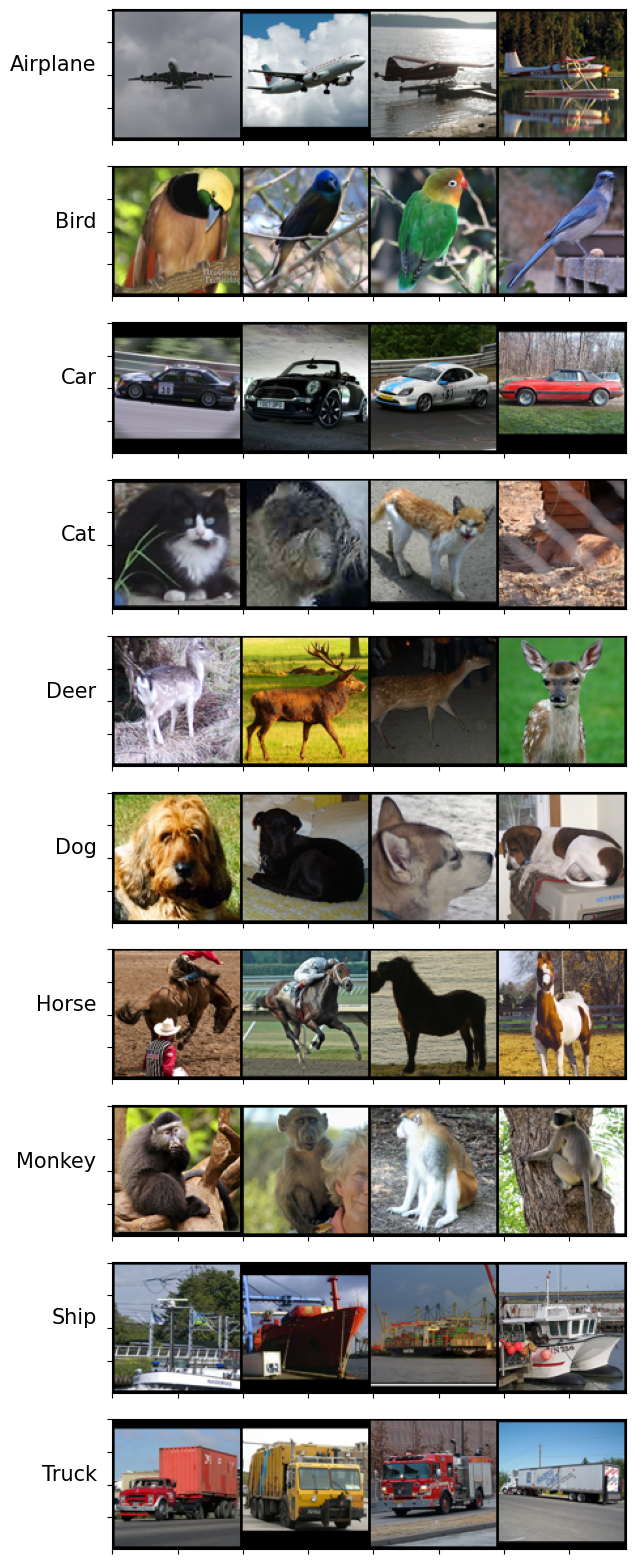

In [75]:
# create true labels
true_labels =  ["Airplane",  # index 0
                "Bird",      # index 1
                "Car",       # index 2 
                "Cat",       # index 3 
                "Deer",      # index 4
                "Dog",       # index 5
                "Horse",     # index 6 
                "Monkey",    # index 7 
                "Ship",      # index 8 
                "Truck"]     # index 9

# load the data that is about to be visualized.
def load_visualized_data():
    set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform = transformation.ToTensor())
    loader = torch.utils.data.DataLoader(set)
    return loader

# Visualize the data.
def visualize_data(num_images_per_label: int = 4, image_width: int = 3, image_size: int = 96) -> None:
    # Load visualized data
    loader = load_visualized_data()

    # Create subplots for each label
    fig, axes = plt.subplots(10, 1, figsize=(48, 20))
    axes = axes.flatten()

    # Initialize iterator for the data loader
    iterator = iter(loader)

    # Iterate through each label
    for index, label in enumerate(true_labels):
        example_index = 0
        class_examples_tensor = torch.empty(num_images_per_label, image_width, image_size, image_size)

        # Collect examples for the current label
        while example_index < num_images_per_label:
            # Move the iterator forward by the random number of places
            random_steps = rnd.randint(1, 10)
            for _ in range(random_steps):
                next(iterator)
        
            example, l = next(iterator)
            if l == index:
                class_examples_tensor[example_index, :, :, :] = example
                example_index += 1
        
        # Display images for the current label
        axes[index].imshow(np.transpose(torchvision.utils.make_grid(class_examples_tensor), (1, 2, 0)))
        axes[index].set_ylabel(str(label), rotation='horizontal', fontsize=15, horizontalalignment='right')
    
    # Remove ticks from the subplots
    for ax in axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    
    # Show the plot
    plt.show()

# Visualize data
visualize_data()

### Pre-processing of the data

In [76]:
# Function to load and preprocess the data using PyTorch DataLoader
def load_and_preprocess_data(train_batch: int = 64, test_batch: int = 64, train_size: float = 0.8, seed: int = 208520262, crop: int = 64, mean: tuple = (0.5, 0.5, 0.5), std: tuple = (0.5, 0.5, 0.5) ) -> tuple:
    # Define transformations for training data
    trans_train = transformation.Compose([transformation.ToTensor(),
                                                transformation.RandomCrop(crop),
                                                transformation.Normalize(mean, std),
                                                transformation.RandomRotation(20),
                                                transformation.RandomAffine(5)])
    
    # Define transformations for validation and test data
    trans_test = transformation.Compose([transformation.ToTensor(),
                                                transformation.CenterCrop(crop),
                                                transformation.Normalize(mean, std)])

    # Load training, validation, and test data from STL10 dataset
    train_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=trans_train)
    val_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=trans_test)
    test_data = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=trans_test)

    # Extract labels from training data
    labels = train_data.labels
    
    # Generate indices for training and validation split
    targets_idx = np.arange(len(labels))
    train_idx, val_idx = train_test_split(targets_idx, train_size=train_size, random_state=seed, shuffle=True, stratify=labels)

    # Define samplers for training and validation sets
    train_sample = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sample = torch.utils.data.SubsetRandomSampler(val_idx)

    # Create DataLoader instances for training, validation, and test sets
    load_train = torch.utils.data.DataLoader(train_data, batch_size=train_batch, sampler=train_sample)
    load_val = torch.utils.data.DataLoader(val_data, batch_size=test_batch, sampler=val_sample)
    load_test = torch.utils.data.DataLoader(test_data, batch_size=test_batch)

    # Return the DataLoader instances along with the labels
    return load_train, load_val, load_test, labels

# Load the preprocessed data using default parameters
load_train, load_val, load_test, labels = load_and_preprocess_data()


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Example of each augmentation

Files already downloaded and verified
Files already downloaded and verified


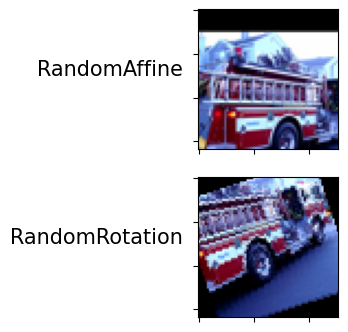

In [77]:
# example of the augmentations
def plot_augmentations(crop: int = 64) -> None:
    # Define augmentation transformations
    randomaffine = transformation.Compose([transformation.ToTensor(),
                                            transformation.RandomCrop(crop),
                                            transformation.RandomAffine(5)])
    randomrotation = transformation.Compose([transformation.ToTensor(),
                                             transformation.RandomCrop(crop),
                                             transformation.RandomRotation(20)])

    # Create datasets with different augmentations
    random_affine_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=randomaffine)
    random_rotation_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=randomrotation)

    # Create data loaders
    affine_loader = torch.utils.data.DataLoader(random_affine_data)
    rotation_loader = torch.utils.data.DataLoader(random_rotation_data)

    # Initialize iterators
    iterator_affine = iter(affine_loader)
    iterator_rotation = iter(rotation_loader)

    # Plot examples of augmentations
    _, axes = plt.subplots(2, 1, figsize=(8, 4))
    axes = axes.flatten()

    # Move iterators forward by random steps
    random_steps = rnd.randint(1, 10)
    for _ in range(random_steps):
        next(iterator_affine)
        next(iterator_rotation)

    # Retrieve examples from iterators
    example_affine, _ = next(iterator_affine)
    example_rotation, _ = next(iterator_rotation)

    # Display images with their respective augmentation types
    axes[0].imshow(np.transpose(torchvision.utils.make_grid(example_affine), (1, 2, 0)))
    axes[0].set_ylabel('RandomAffine', rotation='horizontal', fontsize=15, horizontalalignment='right')
    axes[1].imshow(np.transpose(torchvision.utils.make_grid(example_rotation), (1, 2, 0)))
    axes[1].set_ylabel('RandomRotation', rotation='horizontal', fontsize=15, horizontalalignment='right')

    # Remove axis labels
    for ax in axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()

plot_augmentations()

### 1. Logistic regression over flattened version of the images

In [78]:
# Class definition for multi-class logistic regression model
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        # Initialize the module
        super(LogisticRegression, self).__init__()
        # Flatten input features
        self.flatten = torch.nn.Flatten(start_dim=1)
        # Define linear layer
        self.layer = torch.nn.Linear(input_dim, output_dim)

    def forward(self, features: np.ndarray):
        # Flatten the input features
        flattened_features = self.flatten(features)
        # Pass the flattened features through the linear layer
        predictions = self.layer(flattened_features)
        return predictions

### 2. Fully-connected NN with at least 3 hidden layers over flattened version of the images followed by a classification layer.

Applied batch normalization and dropout to all hidden layers.

In [79]:
# Definition of a fully connected neural network with dropout and batch normalization
class FullyConnectedNet(torch.nn.Module):
    def __init__(self, layer_size: list, drop_percentage: float):
        # Initialize the module
        super(FullyConnectedNet, self).__init__()
        # Flatten input features
        self.flatten = torch.nn.Flatten(start_dim=1)
        # Define fully connected layers
        self.layer1 = torch.nn.Linear(layer_size[0], layer_size[1])
        self.normalize1 = torch.nn.BatchNorm1d(layer_size[1])
        self.dropout1 = torch.nn.Dropout(p=drop_percentage)
        self.layer2 = torch.nn.Linear(layer_size[1], layer_size[2])
        self.normalize2 = torch.nn.BatchNorm1d(layer_size[2])
        self.dropout2 = torch.nn.Dropout(p=drop_percentage)
        self.layer3 = torch.nn.Linear(layer_size[2], layer_size[3])
        self.normalize3 = torch.nn.BatchNorm1d(layer_size[3])
        self.dropout3 = torch.nn.Dropout(p=drop_percentage)
        # Classification layer
        self.output = torch.nn.Linear(layer_size[3], layer_size[4])

    def forward(self, features: np.ndarray, activation_function: torch.nn.functional = torch.nn.functional.relu):
        # Flatten the input features
        flattened_features = self.flatten(features)
        # Pass through the first hidden layer with dropout and batch normalization
        data_after_hidden_1 = self.dropout1(activation_function(self.normalize1(self.layer1(flattened_features))))
        # Pass through the second hidden layer with dropout and batch normalization
        data_after_hidden_2 = self.dropout2(activation_function(self.normalize2(self.layer2(data_after_hidden_1))))
        # Pass through the third hidden layer with dropout and batch normalization
        data_after_hidden_3 = self.dropout3(activation_function(self.normalize3(self.layer3(data_after_hidden_2))))
        # Output layer
        predictions = self.output(data_after_hidden_3)
        return predictions

### CNN with at least two convolution layers and two pooling layers followed by two fully connected layers and a classification layer.
Applied batch normalization to the convolution layers and dropout to the fully connected layers.

In [80]:
# Definition of a convolutional neural network with dropout and batch normalization
class ConvNet(torch.nn.Module):
    def __init__(self, channel_size: list, kernel_size: list, fclayer_size: list, drop_percentage: float = 0.3, pool_size: int = 2):
        # Initialize the module
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.conv1 = torch.nn.Conv2d(channel_size[0], channel_size[1], kernel_size[0])
        self.normalize1 = torch.nn.BatchNorm2d(channel_size[1])
        self.pooling1 = torch.nn.MaxPool2d(pool_size, pool_size)
        self.conv2 = torch.nn.Conv2d(channel_size[1], channel_size[2], kernel_size[1])
        self.normalize2 = torch.nn.BatchNorm2d(channel_size[2])
        self.pooling2 = torch.nn.MaxPool2d(pool_size, pool_size)
        # Fully connected layers
        self.fullyconnected1 = torch.nn.Linear(fclayer_size[0], fclayer_size[1])
        self.dropout1 = torch.nn.Dropout(p=drop_percentage)
        self.fullyconnected2 = torch.nn.Linear(fclayer_size[1], fclayer_size[2])
        self.dropout2 = torch.nn.Dropout(p=drop_percentage)
        self.output = torch.nn.Linear(fclayer_size[2], fclayer_size[3]) 

    def forward(self, features: np.ndarray, activation_function: torch.nn.functional = torch.nn.functional.relu):
        # Pass through the first convolutional layer with dropout and batch normalization
        data_after_conv1 = self.pooling1(activation_function(self.normalize1(self.conv1(features))))
        # Pass through the second convolutional layer with dropout and batch normalization
        data_after_conv2 = self.pooling2(activation_function(self.normalize2(self.conv2(data_after_conv1))))
        # Flatten the output of the second convolutional layer
        data_after_conv2 = data_after_conv2.view(-1, self.fullyconnected1.in_features)
        # Pass through the first fully connected layer with dropout
        data_after_FC1 = self.dropout1(activation_function(self.fullyconnected1(data_after_conv2)))
        # Pass through the second fully connected layer with dropout
        data_after_FC2 = self.dropout2(activation_function(self.fullyconnected2(data_after_FC1)))
        # Output layer
        predictions = self.output(data_after_FC2)
        return predictions


In [81]:
# Function to calculate the size of the first fully connected layer after the CNN
def get_length_of_fully_connected_layer(channel_size, kernel_size, pool_size):
    # Calculate the size of the image after the first convolutional layer and pooling
    img_size = (((channel_size[-1] - kernel_size[0] + 1) // pool_size) - kernel_size[1] + 1) // pool_size
    # Calculate the length of the fully connected layer
    return channel_size[-1] * img_size * img_size 

### A fixed pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer.
we studied only the parameters of the task head.

In [82]:
# Definition of a pre-trained MobileNetV2 model fixed as a feature extractor, followed by fully connected layers
class Fixed_MobileNetV2(torch.nn.Module):
    def __init__(self, layer_size: list, pretrained: bool = True):
        # Initialize the module
        super(Fixed_MobileNetV2, self).__init__()
        # Load pre-trained MobileNetV2
        self.mobilenetv2 = torchvision.models.mobilenet_v2(pretrained)
        # Freeze parameters in MobileNetV2
        for param in self.mobilenetv2.parameters():
            param.requires_grad = False
        # Define fully connected layers
        self.layer1 = torch.nn.Linear(self.mobilenetv2.classifier[1].out_features, layer_size[0])
        self.layer2 = torch.nn.Linear(in_features=layer_size[0], out_features=layer_size[1])
        self.output = torch.nn.Linear(layer_size[1], layer_size[2])
        

    def forward(self, features, activation_function: torch.nn.functional = torch.nn.functional.relu):
        # Extract features using MobileNetV2
        MobileNetV2_features = activation_function(self.mobilenetv2(features))
        # Pass through the first fully connected layer
        data_after_layer_1 = activation_function(self.layer1(MobileNetV2_features))
        # Pass through the second fully connected layer
        data_after_layer_2 = activation_function(self.layer2(data_after_layer_1))
        # Output layer
        predictions = self.output(data_after_layer_2)
        return predictions

### . A learned pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer.
we studied the parameters of the MobileNetV2 as well.

In [83]:
# Definition of a pre-trained MobileNetV2 model with learned features, followed by fully connected layers
class Learned_MobileNetV2(torch.nn.Module):
    def __init__(self, layer_size: list, pretrained: bool = True):
        # Initialize the module
        super(Learned_MobileNetV2, self).__init__()
        # Load pre-trained MobileNetV2
        self.mobilenetv2 = torchvision.models.mobilenet_v2(pretrained)
        # Define fully connected layers
        self.layer1 = torch.nn.Linear(self.mobilenetv2.classifier[1].out_features, layer_size[0])
        self.layer2 = torch.nn.Linear(in_features=layer_size[0], out_features=layer_size[1])
        self.output = torch.nn.Linear(layer_size[1], layer_size[2])


    def forward(self, features, activation_function: torch.nn.functional = torch.nn.functional.relu):
        # Extract features using MobileNetV2
        MobileNetV2_features = activation_function(self.mobilenetv2(features))
        # Pass through the first fully connected layer
        data_after_layer_1 = activation_function(self.layer1(MobileNetV2_features))
        # Pass through the second fully connected layer
        data_after_layer_2 = activation_function(self.layer2(data_after_layer_1))
        # Output layer
        predictions = self.output(data_after_layer_2)
        return predictions

### testing function for the test data on a trained model

In [84]:
# Function to test a trained model on the test data
def test(load_test: torch.utils.data.dataloader, model, device):
    # Define the criterion for evaluation
    crit = torch.nn.CrossEntropyLoss()
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables for tracking total loss, total correct predictions, and total samples
    total_loss ,total_correct ,test_total  = 0, 0, 0
    # Disable gradient calculation during inference
    with torch.no_grad():
        # Iterate over batches in the test data
        for n_batch, data in enumerate(load_test):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            predictions = model(features)
            # Calculate the accuracy and update total correct predictions
            _, predicted = torch.max(predictions.data, 1)
            test_total += labels.size(0)
            total_correct += sum((predicted == labels)).item()
            # Calculate the loss and update total loss
            loss = crit(predictions, labels)
            total_loss += loss.item()

    # Calculate accuracy and average loss
    accuracy = total_correct / test_total
    loss = total_loss / (n_batch + 1)  # Average loss per batch
    return accuracy, loss

### training a model and validating it using the test function

In [85]:
# Function to train a model and validate it using the test function
def train_net(load_train: torch.utils.data.dataloader, load_val: torch.utils.data.dataloader, model, device, optim: str, lr: float = 0.001, n_epochs: int = 200, moment: float = 0.2, wd: float = 0.05):
    # Initialize the optimizer based on the specified optimization algorithm
    if optim == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=moment, weight_decay=wd)
    elif optim == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    else:
        raise ValueError("Optimizer should be 'sgd' or 'adam'.")

    crit = torch.nn.CrossEntropyLoss()
    # Initialize lists to store training and validation loss, and training and validation accuracy
    train_loss, val_loss, train_acc, val_acc = ([] for _ in range(4))

    # Loop through epochs
    for epoch in range(n_epochs):
        model.train()
        total_loss ,total_correct ,train_total  = 0, 0, 0

        # Loop through batches in the training data
        for n_batch, data in enumerate(load_train):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            predictions = model(features)
            loss = crit(predictions, labels)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            total_correct += sum(predicted == labels).item()
            train_total += labels.size(0)

        # Evaluate the model on validation data
        v_acc, v_loss = test(load_val, model, device)

        # Store training and validation metrics
        train_loss.append(total_loss / n_batch)
        train_acc.append(total_correct / train_total)
        val_acc.append(v_acc)
        val_loss.append(v_loss)

        # Print progress
        percentage = (epoch * 100) // n_epochs
        print("Model Training: " + str(percentage) + "%", end="\r")

    return train_loss, val_loss, train_acc, val_acc, model

### Plot loss

In [86]:
# Function to plot loss and accuracy vs epochs
def plot_loss(train_loss, val_loss, train_acc, val_acc, epochs, lr, optimizer, l2_reg):
    # Generate steps for the x-axis
    steps = np.arange(epochs)
    
    # Create a figure with two y-axes
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    # Plot training and validation loss
    ax1.plot(steps, train_loss, label="Train Loss", color='red')
    ax1.plot(steps, val_loss, label="Validation Loss", color='blue')

    # Create another y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')
    
    # Plot training and validation accuracy
    ax2.plot(steps, train_acc, label="Train Accuracy", color='green')
    ax2.plot(steps, val_acc, label="Validation Accuracy", color='yellow')

    # Add legend
    fig.legend(loc='center right', bbox_to_anchor=(0.8, 0.6))
    # Add title with hyperparameters
    fig.suptitle('Learning Rate={}, L2 Regularization Factor={}, Optimizer={}'.format(lr, l2_reg, optimizer))
    fig.tight_layout()
    # Show the plot
    plt.show()

### Define parameters
At first, we tested different configurations of hyperparameters: layer size, optimizer, batch size, learning rate, regularization coefficient, etc.
The parameters we tested are in the note next to the final parameters that turned out to be the best (and for which we drew the graph as requested in the task).

In [88]:
# Set epoch, learning rate, optimizer, L2 regularization, and seed
epochs = [150, 200, 200, 100, 100]  # Number of epochs for each model
lr = [0.00005, 0.001, 0.0001, 0.00015, 0.0001]  # Learning rates for each model
optim = ['sgd', 'sgd', 'adam', 'adam', 'sgd']  # Optimizers for each model
l2_reg = [0.01, 0.01, 0.0001, 0.00005, 4e-05]  # L2 regularization coefficients for each model
momentu = [0.2, 0.25, 0, 0, 0.9]  # Momentum for SGD optimizer for each model
seed = 208520262  # Random seed for reproducibility

# Set batch size and split into train/validation
train_batch_size = 128  # Batch size for training data
test_batch_size = 128  # Batch size for test data
train_part = 0.75  # Percentage of data used for training

# Set CUDA settings
cuda = True  # Whether to use CUDA
use_cuda = cuda and torch.cuda.is_available()  # Whether CUDA is available and selected
device = torch.device("cuda" if use_cuda else "cpu")  # Set device to CUDA if available, otherwise CPU
np.random.seed(seed)  # Set random seed for NumPy
torch.manual_seed(seed)  # Set random seed for PyTorch CPU
if use_cuda:
    torch.cuda.manual_seed(seed)  # Set random seed for PyTorch CUDA
    torch.cuda.manual_seed_all(seed)  # Set random seed for all GPUs
torch.backends.cudnn.enabled = use_cuda  # Enable cuDNN if CUDA is used
torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmark mode
torch.backends.cudnn.deterministic = True  # Ensure reproducible results with cuDNN

# Load data via the load_and_preprocess_data function
load_train, load_val, load_test, labels = load_and_preprocess_data(train_batch_size, test_batch_size, train_part, seed)

# Set models
input_size = 64 * 64 * 3  # Input size for models
# Output size should be determined based on the dataset, but it's missing here.
# Assuming it will be determined later.
output_size = len(true_labels)  # Output size for models, but true_labels is not defined.
LR = LogisticRegression(input_dim=input_size, output_dim=output_size).to(device)  # Logistic regression model
hidden1_size = 200  # Size of the first hidden layer for fully connected networks
hidden2_size = 100  # Size of the second hidden layer for fully connected networks
hidden3_size = 50  # Size of the third hidden layer for fully connected networks
layers = [input_size, hidden1_size, hidden2_size, hidden3_size, output_size]  # Layer sizes for fully connected networks
dropout_precentage = 0.3  # Dropout percentage for fully connected networks
FCNN = FullyConnectedNet(layer_size=layers, drop_percentage=dropout_precentage).to(device)  # Fully connected neural network
channel_size = [3, 20, 64]  # Channel sizes for convolutional neural networks
kernel_size = [3, 3]  # Kernel sizes for convolutional neural networks
pool = 2  # Pool size for convolutional neural networks
fclayer_size = [get_length_of_fully_connected_layer(channel_size, kernel_size, pool), 100, 50, 10]  # Fully connected layer sizes for CNNs
CNN = ConvNet(channel_size, kernel_size, fclayer_size, pool_size=pool).to(device)  # Convolutional neural network
layer_size = [500, 100, output_size]  # Layer sizes for fixed MobileNetV2
FMNV2 = Fixed_MobileNetV2(layer_size).to(device)  # Fixed MobileNetV2 model
LMNV2 = Learned_MobileNetV2(layer_size).to(device)  # Learned MobileNetV2 model

models = [LR, FCNN, CNN, FMNV2, LMNV2]  # List of all models

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


c:\Users\Lenovo\anaconda3\envs\dl_biu\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\dl_biu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Running the networks

Model: LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer): Linear(in_features=12288, out_features=10, bias=True)
), Learning Rate: 5e-05, Optimizer: sgd, L2 Regularization: 0.01, Epochs: 150
Train Accuracy: 0.260
Train Loss: 2.126
Validation Accuracy: 0.278
Validation Loss: 2.021
Test Accuracy: 0.281
Test Loss:2.015


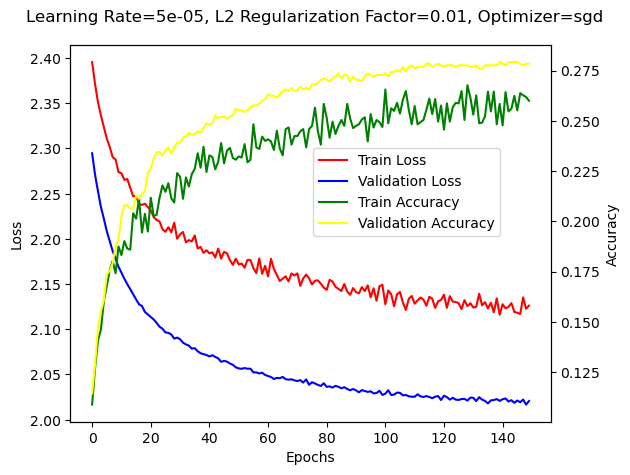

Model: FullyConnectedNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=12288, out_features=200, bias=True)
  (normalize1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=200, out_features=100, bias=True)
  (normalize2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (layer3): Linear(in_features=100, out_features=50, bias=True)
  (normalize3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=50, out_features=10, bias=True)
), Learning Rate: 0.001, Optimizer: sgd, L2 Regularization: 0.01, Epochs: 200
Train Accuracy: 0.294
Train Loss: 1.981
Validation Accuracy: 0.362
Validation Loss: 1.798
Test Accuracy: 0.354
Test Loss:1.805


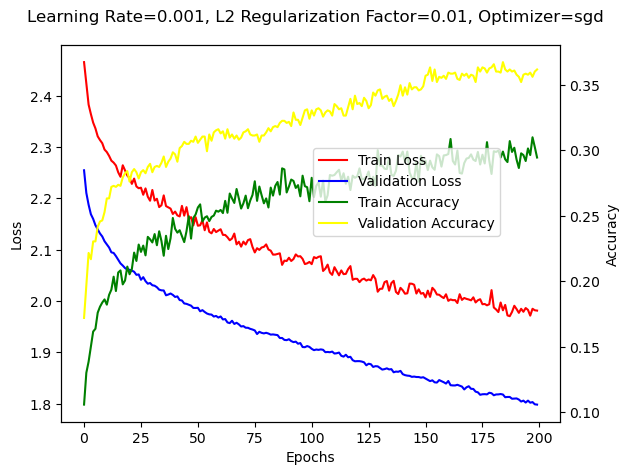

Model: ConvNet( 99%
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (normalize1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1))
  (normalize2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fullyconnected1): Linear(in_features=12544, out_features=100, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fullyconnected2): Linear(in_features=100, out_features=50, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=50, out_features=10, bias=True)
), Learning Rate: 0.0001, Optimizer: adam, L2 Regularization: 0.0001, Epochs: 200
Train Accuracy: 0.543
Train Loss: 1.288
Validation Accuracy: 0.600
Validation Loss: 1.093
Test Accuracy: 0.

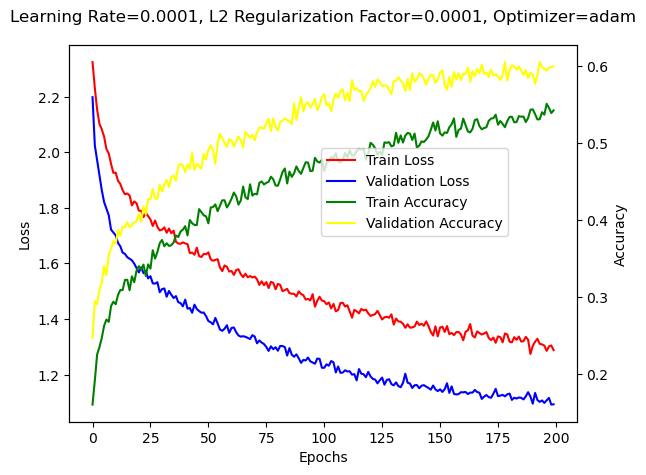

Model: Fixed_MobileNetV2(
  (mobilenetv2): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 9

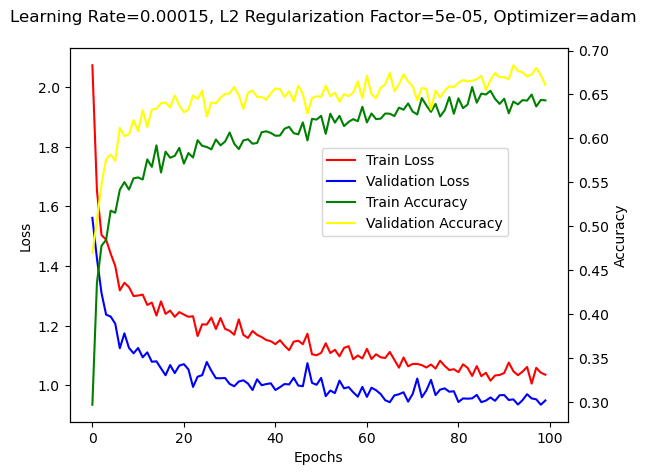

Model: Learned_MobileNetV2(
  (mobilenetv2): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16,

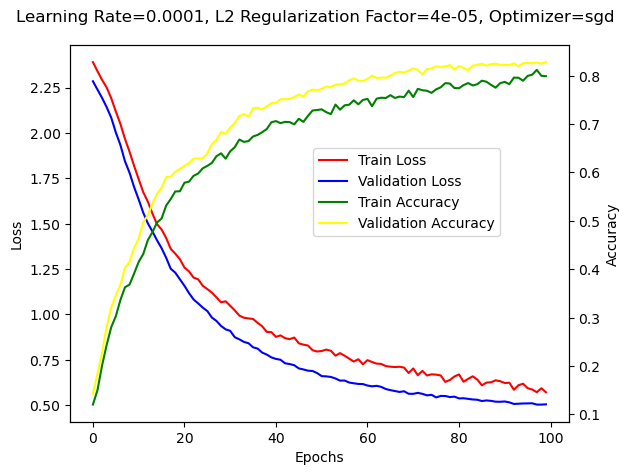

In [56]:
# Plot all models
for idx, model in enumerate(models):
    # Train the model
    train_loss, val_loss, train_acc, val_acc, model = train_net(load_train, load_val, model, device, optim[idx], lr[idx], epochs[idx], momentu[idx], l2_reg[idx])
    # Test the model
    test_acc, test_loss = test(load_test, model, device)
    # Print results
    print('Model: {0}, Learning Rate: {1}, Optimizer: {2}, L2 Regularization: {3}, Epochs: {4}'.format(model, lr[idx], optim[idx], l2_reg[idx], epochs[idx]))
    print('Train Accuracy: {0:.3f}\nTrain Loss: {1:.3f}\nValidation Accuracy: {2:.3f}\nValidation Loss: {3:.3f}\nTest Accuracy: {4:.3f}\nTest Loss:{5:.3f}'.format(train_acc[-1], train_loss[-1],val_acc[-1], val_loss[-1], test_acc, test_loss))
    # Plot loss and accuracy
    plot_loss(train_loss, val_loss, train_acc, val_acc, epochs[idx], lr[idx], optim[idx], l2_reg[idx])
